# Проект-6. Сегментация клиентов онлайн-магазина подарков.

*Этапы работы над проектом*  

*  **Подготовка к предобработке и анализу**
>
*  **Разведывательный анализ**
>  
*  **Построение RFM-таблицы и кластеризация клиентов**
   -  Оценка и удаление выбросов в RFM-таблице
   -  PCA. Стандартизация и уменьшение размерности
   -  Выбор алгоритма кластеризации
   -  Визуализация кластеров
   -  Построение профиля кластеров
   -  Интерпретация результатов кластеризации
>
*  **Вывод**


## Основные цели:

1.  Произвести предобработку набора данных.
2.  Провести разведывательный анализ данных и выявить основные закономерности.
3.  Сформировать категории товаров и клиентов.
4.  Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.

## Описанние структуры данных

*    `InvoiceNo` — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква '**C**' в начале кода указывает на отмену транзакции);
*    `StockCode` — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
*    `Description` — название товара;
*    `Quantity` — количество каждого товара за транзакцию;
*    `InvoiceDate` — дата и время выставления счёта/проведения транзакции;
*    `UnitPrice` — цена за единицу товара в фунтах стерлингов;
*    `CustomerID` — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
*    `Country` — название страны, в которой проживает клиент.

# Подготовка к предобработке и анализу

<span style="font-size: 18px; font-weight: bold;">Загрузка библиотек</span>

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# from sklearn import cluster
# from sklearn import metrics
# from sklearn import pipeline
# from sklearn import preprocessing
# from sklearn import ensemble
# from sklearn import model_selection
# from sklearn import mixture
# from sklearn import manifold
# from sklearn import decomposition

from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

#  yellowbrick helper
from yellowbrick.cluster import KElbowVisualizer


# Внутриние метрики:
# Коэффициент силуэта
from sklearn.metrics.cluster import silhouette_score
# Индекс Калински — Харабаса
from sklearn.metrics.cluster import calinski_harabasz_score
# индекс Дэвиса — Болдина
from sklearn.metrics.cluster import davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

#display=display; 
from IPython.display import HTML, IFrame, display
DF=pd.DataFrame; S=pd.Series


sns.set();
sns.set_theme("notebook") 
# sns.set_palette("muted")
sns.set_palette("Set2") 

#
# sns.set_theme("notebook"); sns.set_palette("muted") # Set2, tab10, tab20
# fgsz_save=rcParams['figure.figsize']
# rc_fig_width=5.4; rcParams['figure.figsize']=(rc_fig_width, rc_fig_width*480/540) #3/4 (.75), 3.6/4

In [2]:
%%bash

# Каталог для хранения диаграмм plotly
mkdir -p frames

<span style="font-size: 18px; font-weight: bold;">Загрузка Данных</span>

In [3]:
#
data_df = pd.read_csv("./data/data.zip", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceNo': str})
data_df_shape = data_df.shape
print(f'Data shape:\nRows: {data_df_shape[0]}, Columns: {data_df_shape[1]}')

Data shape:
Rows: 541909, Columns: 8


In [2]:
data_df = pd.read_csv(
    "customer_segmentation_project.zip", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data_df.shape))
data_df.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


## <span style="font-size: 18px; font-weight: bold;">Первичная оценка "сырых" данных</span>

In [4]:
#
data_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [3]:
#
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


*  +  -

## <span style="font-size: 18px; font-weight: bold;">Обработка пропусков и дубликатов</span>

<span style="font-size: 18px; font-weight: bold;">Удаление пропусков</span>

In [4]:
# Кол-во пропусков в признаках
data_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

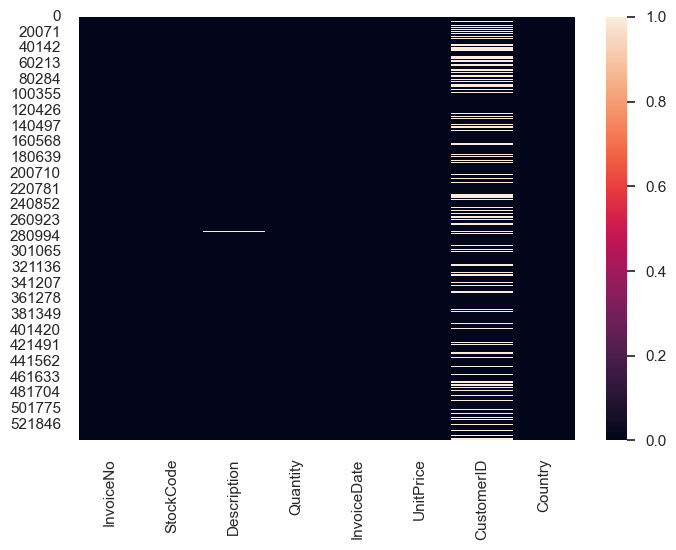

In [7]:
# Визуальая оценка пропусков
sns.heatmap(data_df.isnull());

In [5]:
# Удаление и контроль
data_df.dropna(subset=['CustomerID'], inplace=True)
data_df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

*  +  -

## <span style="font-size: 18px; font-weight: bold;">Удаление дубликатов</span>

In [6]:
#
print(f'Количество дубликатов: {data_df.duplicated().sum()}')
#
data_df.drop_duplicates(inplace=True)

Количество дубликатов: 5225


*  +  -

## <span style="font-size: 18px; font-weight: bold;">Заказы с нулевой стоимостью</span>

In [7]:
#
print(f'Колчество заказов с нулевой стоимостью: {(data_df.UnitPrice == 0).sum()}')
# drop inplace
data_df.drop(index=data_df[data_df.UnitPrice == 0].index, inplace=True)
#print(f'Control Count: {(data_df.UnitPrice == 0).sum()}')

Колчество заказов с нулевой стоимостью: 40


*  +  -

## <span style="font-size: 18px; font-weight: bold;">Cпециализированные транзакции</span>

In [8]:
#
print(f"Кол-во спец. транзакций: {data_df.StockCode.str.match('[a-zA-Z]+').sum()}\n")
print("По типу транзакции:")
data_df.StockCode[data_df.StockCode.str.match('[a-zA-Z]+')].value_counts()

Кол-во спец. транзакций: 1908

По типу транзакции:


StockCode
POST            1196
M                454
C2               134
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               3
Name: count, dtype: int64

In [9]:
# drop inplace
data_df.drop(index=data_df[data_df.StockCode.str.match('[a-zA-Z]+')].index, inplace=True)

*  +  -

## <span style="font-size: 18px; font-weight: bold;">Дата/Время</span>

In [10]:
#
data_df['InvoiceDateTime'] = pd.to_datetime(data_df.InvoiceDate)
# data_df['InvoiceDate'] = data_df.InvoiceDateTime.dt.date
# data_df['InvoiceTime'] = data_df.InvoiceDateTime.dt.time

# Конструирование признаков дата/время будем делать по мере необходимости
data_df.drop(['InvoiceDate'], axis='columns', inplace=True)

*  +  -

## <span style="font-size: 18px; font-weight: bold;">Корректирующие транзакции</span>

<span style="font-size: 16px; font-weight: bold;">Функция для создания признака количества отменённых заказов</span>

In [11]:
from tqdm import tqdm

def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов.
    
    Функция принимает на вход таблицу и возвращает столбец, в котором 
    указано количество отменённого впоследствии товара для каждой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента,
    признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    # Отображаем прогресс обработки
    with tqdm(total=negative_quantity.shape[0], desc ="Total", ncols = 80) as tqdm_bar:
        
        for index, col in negative_quantity.iterrows():
            # Создаём DataFrame из всех контрагентов
            df_test = data[(data['CustomerID'] == col['CustomerID']) &
                           (data['StockCode']  == col['StockCode']) &
                           (data['InvoiceDateTime'] < col['InvoiceDateTime']) &
                           (data['Quantity'] > 0)].copy()
            # Транзакция-возврат не имеет контрагента — ничего не делаем
            if (df_test.shape[0] == 0):
                # Помечаем столбец как пропуск
                quantity_canceled.loc[index] = np.nan
            # Транзакция-возврат имеет ровно одного контрагента
            # Добавляем количество отменённого в столбец QuantityCanceled
            elif (df_test.shape[0] == 1):
                index_order = df_test.index[0]
                quantity_canceled.loc[index_order] = -col['Quantity']      
            # Транзакция-возврат имеет несколько контрагентов
            # Задаём количество отменённого товара в столбце QuantityCanceled для той транзакции на покупку,
            # в которой количество товара больше количества товаров в транзакции-возврате
            elif (df_test.shape[0] > 1):
                df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
                for ind, val in df_test.iterrows():
                    if val['Quantity'] < -col['Quantity']:
                        continue
                    quantity_canceled.loc[ind] = -col['Quantity']
                    break

            tqdm_bar.update()    
    
    return quantity_canceled

In [12]:
# Обработка
data_df['QuantityCanceled'] = get_quantity_canceled(data_df)

Total:   0%|                                   | 2/8506 [00:00<08:52, 15.97it/s]

Total: 100%|████████████████████████████████| 8506/8506 [07:26<00:00, 19.04it/s]


*  +  -

<span style="font-size: 16px; font-weight: bold;">Отмененные транзакции не имеющие контрагентов</span>

In [13]:
print(f"Кол-во транзакций, не имеющих контрагентов: {data_df['QuantityCanceled'].isna().sum()}")

Кол-во транзакций, не имеющих контрагентов: 1028


In [14]:
# Удаляем транзкации не имеющие контрагентов
data_df.drop(index=data_df[data_df['QuantityCanceled'].isna()].index, inplace=True)

# Оставшиеся приводим к целочисленому типу
data_df.QuantityCanceled = data_df.QuantityCanceled.astype(int)

## Удаляем транзакции с отризательным количеством товара
data_df.drop(index=data_df[data_df.Quantity < 0].index, inplace=True)

<span style="font-size: 16px; font-weight: bold;">Признак: Общая стоимость товара в транзакции</span>

In [15]:
#
data_df['TotalPrice'] = data_df.UnitPrice * (data_df.Quantity - data_df.QuantityCanceled)

*  -  +

## <span style="font-size: 18px; font-weight: bold;">Точка сохранения</span>

In [19]:
#
data_df.to_csv('./data/prj_6-clean.zip', compression={'method':'zip', 'archive_name':'prj_6-clean.csv'})

In [20]:
# ##  Перезагрузка очищенных данных
# data_df = pd.read_csv('../data/prj_6-clean.zip', index_col=0, dtype={'CustomerID': str,'InvoiceNo': str})
# data_df['InvoiceDateTime'] = pd.to_datetime(data_df.InvoiceDateTime)
# data_df.info()

## <span style="font-size: 18px; font-weight: bold;">Выборочные статистики по датасету</span>

In [16]:
#
print("\nПериод выборки")
print('Начало : {first}\nКонец :  {last}'
      .format(**data_df.InvoiceDateTime.describe()[['first', 'last']].to_dict()))


Период выборки


KeyError: "None of [Index(['first', 'last'], dtype='object')] are in the [index]"

In [17]:
# Общии статистики в числовых признаках
data_df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,391150.000000,391150.000000
mean,13.145300,2.874372
std,180.807831,4.284738
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


* **Кратное** завышение в **max** - наличие **выбросов** или аномально высоких значений

In [18]:
# Общии статистики в категориях
print('Общии статистики в категориях')
data_df.describe(include='object').T

Общии статистики в категориях


,count,unique,top,freq
InvoiceNo,391150,18402,576339,541
StockCode,391150,3659,85123A,2023
Description,391150,3871,WHITE HANGING HEART T-LIGHT HOLDER,2016
CustomerID,391150,4334,17841,7667
Country,391150,37,United Kingdom,348872


In [19]:
#
data_df.nunique() #describe().T

InvoiceNo           18402
StockCode            3659
Description          3871
Quantity              299
UnitPrice             355
CustomerID           4334
Country                37
InvoiceDateTime     17166
QuantityCanceled      122
TotalPrice           3155
dtype: int64

In [20]:
#
print(f'Общая сумма оплаченных заказов: {(data_df.UnitPrice * (data_df.Quantity - data_df.QuantityCanceled)).sum()}')

Общая сумма оплаченных заказов: 8263592.99


## <span style="font-size: 18px; font-weight: bold;">Общая оценка отобранных данных</span>

*  За период с **1**-го **декабря 2010**-го по **9**-ое **декабря 2011**-го в **18 402**-х заказах **4 334** клиента из **37** стран в **391 150**-и транзакциях заказали **3 659** типов товаров, на общую сумму **8 263 593** *д.е.*

*  -  +

# Разведывательный анализ

## <span style="font-size: 18px; font-weight: bold;">Подготовка к анализу</span>

In [23]:
#
data_df['InvoiceDate'] = data_df.InvoiceDateTime.dt.date
# data_df['InvoiceTime'] = data_df.InvoiceDateTime.dt.time

data_df['InvoiceDay'] = data_df.InvoiceDateTime.dt.day
data_df['InvoiceHour'] = data_df.InvoiceDateTime.dt.hour
data_df['InvoiceMonth'] = data_df.InvoiceDateTime.dt.month
data_df['InvoiceWeekDay'] = data_df.InvoiceDateTime.dt.day_of_week

data_df['MonthName'] = data_df.InvoiceDateTime.dt.month_name()
data_df['WeekDayName'] = data_df.InvoiceDateTime.dt.day_name()

## <span style="font-size: 18px; font-weight: bold;">Первые 15 стран по количеству транзакций</span>

In [24]:
#
data_df.groupby('Country')[['InvoiceNo']].agg('count')\
    .sort_values(by='InvoiceNo', ascending=False).head(15)\
    .rename(columns={'InvoiceNo':'Invoices'})\
    .style.bar(align='mid')

,Invoices
Country,
United Kingdom,348872
Germany,8643
France,8019
EIRE,7126
Spain,2417
Netherlands,2322
Belgium,1935
Switzerland,1810
Portugal,1416


*  

## <span style="font-size: 18px; font-weight: bold;">Первые 15 стран по количеству заказов</span>

In [25]:
#
data_df.groupby('Country')[['InvoiceNo']].nunique()\
    .sort_values(by='InvoiceNo', ascending=False).head(15)\
    .rename(columns={'InvoiceNo':'Invoices'})\
    .style.bar(align='mid')

,Invoices
Country,
United Kingdom,16579
Germany,443
France,379
EIRE,256
Belgium,98
Netherlands,93
Spain,88
Australia,56
Portugal,49


*  

## <span style="font-size: 18px; font-weight: bold;">Первые15 стран по количеству товаров (с учетом возврата)</span>

In [26]:
# 
data_df['QuantityReal'] = data_df.Quantity - data_df.QuantityCanceled
#
data_df.groupby('Country')[['QuantityReal']].agg('sum')\
    .sort_values(by='QuantityReal', ascending=False).head(15)\
    .rename(columns={'QuantityReal':'Quantity'})\
    .style.bar(align='mid')

,Quantity
Country,
United Kingdom,4001671
Netherlands,199934
EIRE,135994
Germany,116439
France,109039
Australia,83348
Sweden,35836
Switzerland,29680
Spain,26601


*  

## <span style="font-size: 18px; font-weight: bold;">Первые 15 стран по обороту (с учетом возврата)</span>

In [27]:
#
data_df.groupby('Country')[['TotalPrice']].agg('sum')\
    .sort_values(by='TotalPrice', ascending=False).head(15)\
    .style.format(precision=2).bar(align='mid')

,TotalPrice
Country,
United Kingdom,6797691.44
Netherlands,283443.54
EIRE,247074.57
Germany,201520.71
France,181529.63
Australia,136950.25
Switzerland,51863.75
Spain,51764.90
Belgium,36673.04


*  Все лидирующие позиции занимает Великобритания

## <span style="font-size: 18px; font-weight: bold;">Сезонная активность по заказам(общая)</span>

In [28]:
#
data_df.groupby(['InvoiceMonth','MonthName'])[['InvoiceNo']].nunique()\
    .sort_index()\
    .rename(columns={'InvoiceNo':'InvoiceCount'})\
    .style.bar(align='mid')
#    .sort_values(by='InvoiceNo', ascending=False)\

,,InvoiceCount
InvoiceMonth,MonthName,
1,January,983
2,February,992
3,March,1312
4,April,1139
5,May,1544
6,June,1390
7,July,1321
8,August,1267
9,September,1739


*  Осень - нарастание активности с пиком в ноябре. Спад активности в январе.

## <span style="font-size: 18px; font-weight: bold;">Недельная активность (общая)</span>

In [29]:
#agg('count')
data_df.groupby(['InvoiceWeekDay', 'WeekDayName'])[['InvoiceNo']].nunique()\
    .rename(columns={'InvoiceNo':'InvoiceCount'}).sort_index()\
    .style.bar(align='mid')

,,InvoiceCount
InvoiceWeekDay,WeekDayName,
0,Monday,2830
1,Tuesday,3156
2,Wednesday,3436
3,Thursday,4003
4,Friday,2809
6,Sunday,2168


* *Пик в четверг, спад - пятница, суббота - выходной*

## <span style="font-size: 18px; font-weight: bold;">Первые 15 покупателей по количеству заказов</span>

In [30]:
# customer_activity_by_orders
data_df.groupby('CustomerID')[['InvoiceNo']].agg('count')\
    .rename(columns={'InvoiceNo':'InvoiceCount'})\
    .sort_values(by='InvoiceCount', ascending=False).head(15)\
    .style.bar(align='mid')

,InvoiceCount
CustomerID,
17841,7667
14911,5584
14096,5095
12748,4397
14606,2674
15311,2366
14646,2060
13089,1814
13263,1662


## <span style="font-size: 18px; font-weight: bold;">Первые 15 товаров по продаваемости</span>

In [31]:
# stock_marketability
data_df.groupby(['StockCode', 'Description'])[['InvoiceNo']].agg('count')\
    .rename(columns={'InvoiceNo':'InvoiceCount'})\
    .sort_values(by='InvoiceCount', ascending=False).head(15)\
    .style.bar(align='mid')

,,InvoiceCount
StockCode,Description,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2016
22423,REGENCY CAKESTAND 3 TIER,1713
85099B,JUMBO BAG RED RETROSPOT,1615
84879,ASSORTED COLOUR BIRD ORNAMENT,1395
47566,PARTY BUNTING,1389
20725,LUNCH BAG RED RETROSPOT,1303
22720,SET OF 3 CAKE TINS PANTRY DESIGN,1152
20727,LUNCH BAG BLACK SKULL.,1078
21212,PACK OF 72 RETROSPOT CAKE CASES,1050


*  

## <span style="font-size: 18px; font-weight: bold;">Суточная активность по заказам (общая)</span>

In [32]:
##

# data_df.groupby('InvoiceHour')[['InvoiceNo']].agg('count')\
#     .rename(columns={'InvoiceNo':'InvoiceCount'}).sort_index()\
#     .style.bar(align='mid')

data_df.groupby('InvoiceHour')[['InvoiceNo']].nunique()\
    .rename(columns={'InvoiceNo':'InvoiceCount'}).sort_index()\
    .style.bar(align='mid')

,InvoiceCount
InvoiceHour,
6,1
7,29
8,554
9,1383
10,2204
11,2262
12,3118
13,2623
14,2251


## <span style="font-size: 18px; font-weight: bold;">Среднесуточная активность по транзакциям</span>

In [33]:
data_df.groupby(['InvoiceDate', 'InvoiceHour'])['InvoiceNo'].count()\
    .unstack().fillna(0).mean().to_frame()\
    .rename(columns={0:'Hour Average'})\
    .style.format(precision=2).bar(align='mid')

,Hour Average
InvoiceHour,
6,0.00
7,1.23
8,28.28
9,71.43
10,123.14
11,158.06
12,231.86
13,205.90
14,173.94


## <span style="font-size: 18px; font-weight: bold;">Среднесуточная активность по заказам</span>

In [34]:
data_df.groupby(['InvoiceDate', 'InvoiceHour'])['InvoiceNo'].nunique()\
    .unstack().fillna(0).mean().to_frame()\
    .rename(columns={0:'Hour Average'})\
    .style.format(precision=2).bar(align='mid')

,Hour Average
InvoiceHour,
6,0.00
7,0.10
8,1.82
9,4.53
10,7.23
11,7.42
12,10.22
13,8.60
14,7.38


*  Наибольшая активность приходится на период с 10 до 15 с пиком в 12 часов дня.

## <span style="font-size: 18px; font-weight: bold;">Среднесуточная активность по заказам в разрезе недельной</span>

In [38]:
# data_df[['InvoiceNo', 'InvoiceWeekDay', 'WeekDayName', 'InvoiceHour']].pivot_table(
#     #values='Price',
#     columns='InvoiceHour',
#     index=['InvoiceWeekDay', 'WeekDayName'],
#     fill_value=0,
#     aggfunc='count'
# ).round(2).style.background_gradient(cmap='PuBu')
# #.style.highlight_max()

In [35]:
data_df[['InvoiceNo', 'InvoiceWeekDay', 'WeekDayName', 'InvoiceHour']].pivot_table(
    columns='InvoiceHour',
    index=['InvoiceWeekDay', 'WeekDayName'],
    fill_value=0,
    aggfunc='nunique'
).round(2).style.background_gradient(cmap='PuBu')
#.style.highlight_max()

* Максимальная суточная активность приходиться на середину недели с пиком в четверг.

# <span style="font-size: 18px; font-weight: bold;">Построение RFM-таблицы</span>

*  Recency (давность) — давность последней покупки клиента
*  Frequency (частота) — общее количество покупок клиента
*  Monetary Value (денежная ценность) — сколько денег потратил клиент


<span style="font-size: 16px; font-weight: bold;">Функции-обертки для сохранения и отображения фигур plotly</span>

In [36]:
#
def frame_figure(fig, file_name, height="800", width="100%"):
    """Сохраняет в файл и выводит во фрейме фигуры Plotly
        fig: Объект Figure
        file_name: Имя сохраняемого html файла
        width, height: высота, ширина фрейма для отображения
    """
    fig.write_html(file_name)
    return IFrame(src=file_name, width=width, height=height)

In [37]:
#
def rfm_boxes(rfm_table):
    """ Отрисовка boxplot для RFM таблицы
    """
    boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
    fig = make_subplots(
        rows=1, cols=3, 
        subplot_titles=("Recency","Frequency", "Monetary")
    )
    for i, box in enumerate(boxes):
        fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)
    fig.update_layout(showlegend=True)
    return fig

## <span style="font-size: 18px; font-weight: bold;">Построение RFM-таблицы</span>

In [38]:
# Дата окончания периода
date_x = pd.to_datetime('2011-12-10 00:00:00')

# Основные столбцы RFM датафрейма
rfm_columns = ["Recency", "Frequency", "Monetary"]

data_rfm = data_df.groupby('CustomerID').apply(lambda x: pd.Series(
    {'Recency': (date_x - x.InvoiceDateTime.max()).days,
     'Frequency': x.InvoiceNo.nunique(),
     'Monetary': x.TotalPrice.sum() }))

#
print('Shape:',data_rfm.shape)
data_rfm.head(5)

Shape: (4334, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346,325.0,1.0,0.00
12347,2.0,7.0,4310.00
12348,75.0,4.0,1437.24
12349,18.0,1.0,1457.55
12350,310.0,1.0,294.40


## <span style="font-size: 18px; font-weight: bold;">Визуальная оценка выбросов в RFM-таблице</span>

In [39]:
#
frame_figure(rfm_boxes(data_rfm[rfm_columns]), "frames/frame_2a.html", height="400")

FileNotFoundError: [Errno 2] No such file or directory: 'frames/frame_2a.html'

## <span style="font-size: 18px; font-weight: bold;">Удаление RFM-выбросов</span>

>  По легенде последнии 5% в распределении (`> quantile(95%)`) признаков Frequency и Monetary являются выбросами - удалим их.

In [40]:
# Frequency
data_rfm.drop(index=(data_rfm[data_rfm.Frequency > data_rfm.Frequency.quantile(.95)]).index, inplace=True)
# Monetary
data_rfm.drop(index=(data_rfm[data_rfm.Monetary > data_rfm.Monetary.quantile(.95)]).index, inplace=True)
#
#data_rfm.shape
#
frame_figure(rfm_boxes(data_rfm[rfm_columns]), "frames/frame_2b.html", height="400")

FileNotFoundError: [Errno 2] No such file or directory: 'frames/frame_2b.html'

<span style="font-size: 18px; font-weight: bold;">Поготовка RFM данных к кластеризации</span>

## <span style="font-size: 18px; font-weight: bold;">PCA. Стандартизация и уменьшение размерности</span>

In [45]:
# scaler = StandardScaler()
# X_SCALED = scaler.fit_transform(data_rfm[rfm_columns].values)
# data_rfm_scaled = DF(X_SCALED, columns=rfm_columns)
## data_rfm_scaled.describe().round(3)

In [46]:
# pca = PCA(n_components=2)
# X_PCA = pca.fit_transform(X_SCALED)
# data_pca = DF(X_PCA, columns=['PCA_0', 'PCA_1'])
## data_pca.describe().round(3)

In [41]:
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=2))
])

display(pipeline)
#
X_PCA = pipeline.fit_transform(data_rfm[rfm_columns].values)

print('Shape:', X_PCA.shape)
#
data_pca = DF(X_PCA, columns=['PCA_0', 'PCA_1'])
#data_pca.describe().round(3)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

Shape: (3921, 2)


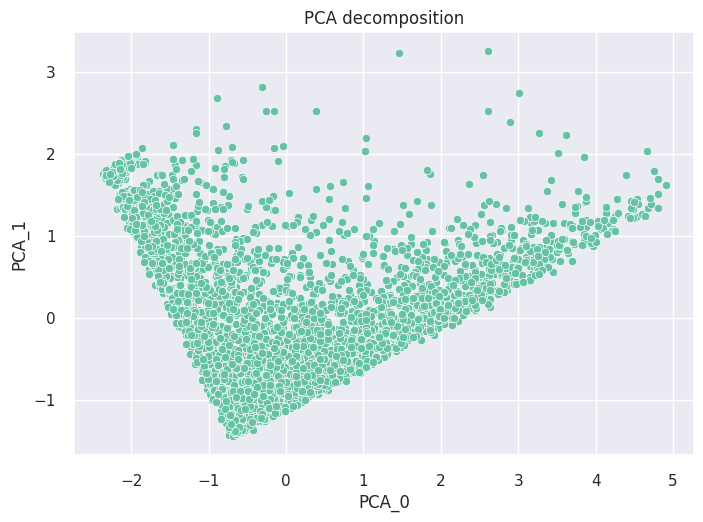

In [42]:
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1')\
.set_title('PCA decomposition');

## <span style="font-size: 18px; font-weight: bold;">Выбор алгоритма кластеризации и визуальная оценка</span>

### SpectralClustering

In [43]:
# Спектральная кластеризация
scores = []
for n_clusters in range(3, 10):
    spectral_ = SpectralClustering(n_clusters=n_clusters, random_state=4242)
    spectral_.fit(X_PCA)
    
    scores.append({
    #    'eps': eps,
        'n_clusters' : n_clusters,
        'score': silhouette_score(X_PCA, spectral_.labels_, metric='euclidean').round(2),  
        'ch_score': calinski_harabasz_score(X_PCA, spectral_.labels_).round(2),
        'db_score': davies_bouldin_score(X_PCA, spectral_.labels_).round(2),
    })
#
DF(scores).sort_values(by='score', ascending=False).head(3)

,n_clusters,score,ch_score,db_score
1,4,0.47,4785.01,0.60
0,3,0.46,4130.98,0.61
2,5,0.42,2643.14,0.71


In [44]:
#
n_clusters = DF(scores).n_clusters[np.argmax(DF(scores).score)]
print(f"Best score clasters count: {n_clusters}\n")
#
spectral_ = SpectralClustering(n_clusters=n_clusters, random_state=4242)
spectral_.fit(X_PCA)
S(spectral_.labels_).value_counts()

Best score clasters count: 4



3    2380
0     742
1     656
2     143
Name: count, dtype: int64

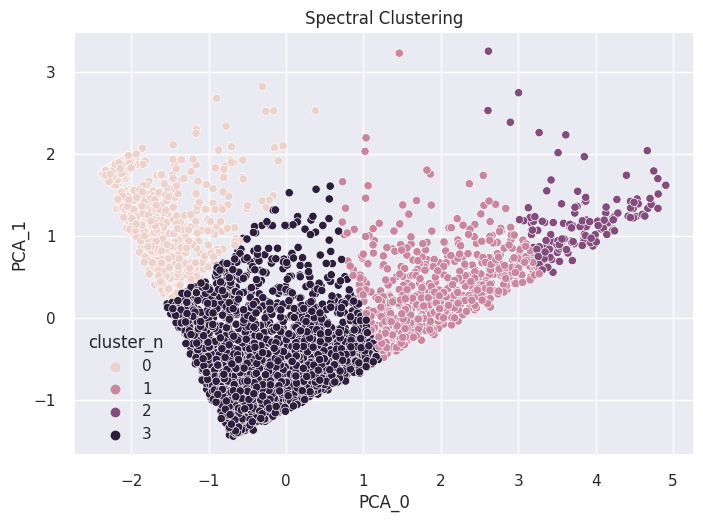

In [45]:
#
data_pca['cluster_n'] = spectral_.labels_
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1', hue='cluster_n')\
    .set_title("Spectral Clustering");

###  AgglomerativeClustering

In [46]:
## Aгломеративная кластеризация
scores = []
for n_clusters in range(3, 10):
    agglomerative_ = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agglomerative_.fit(X_PCA)
    
    scores.append({
    #    'eps': eps,
        'n_clusters' : n_clusters,
        'score': silhouette_score(X_PCA, agglomerative_.labels_, metric='euclidean').round(3),  
        'ch_score': calinski_harabasz_score(X_PCA, agglomerative_.labels_).round(2),
        'db_score': davies_bouldin_score(X_PCA, agglomerative_.labels_).round(2),
    })

DF(scores).sort_values(by='score', ascending=False).head(3)

,n_clusters,score,ch_score,db_score
0,3,0.437,3896.91,0.72
1,4,0.414,4859.81,0.67
2,5,0.409,4895.64,0.73


In [47]:
#
n_clusters = DF(scores).n_clusters[np.argmax(DF(scores).score)]
print(f"Best score clasters count: {n_clusters}\n")
#
agglomerative_ = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agglomerative_.fit(X_PCA)
S(agglomerative_.labels_).value_counts()

Best score clasters count: 3



0    2379
1    1187
2     355
Name: count, dtype: int64

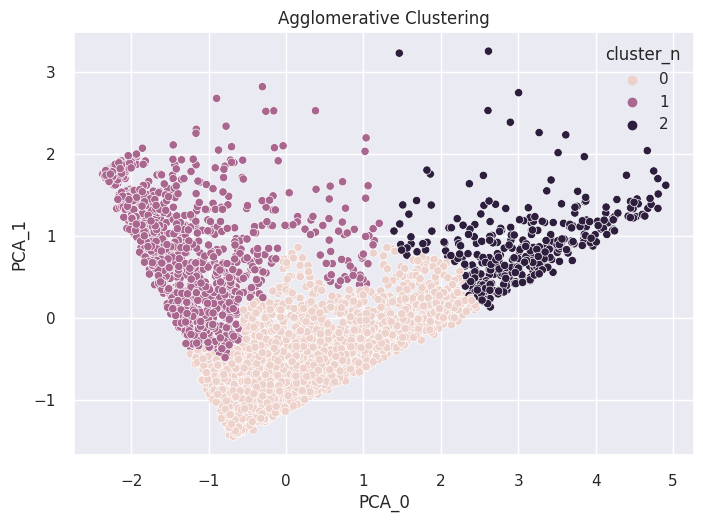

In [48]:
#
data_pca['cluster_n'] = agglomerative_.labels_
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1', hue='cluster_n')\
.set_title("Agglomerative Clustering");

### GaussianMixture

In [49]:
scores = []
for n_clusters in range(3, 11):
    gm_ = GaussianMixture(n_components=n_clusters, random_state=4242)
    gm_.labels_ =  gm_.fit_predict(X_PCA)
    
    scores.append({
    #    'eps': eps,
        'n_clusters' : n_clusters,
        'score': silhouette_score(X_PCA, gm_.labels_, metric='euclidean').round(2),  
        'ch_score': calinski_harabasz_score(X_PCA, gm_.labels_).round(2),
        'db_score': davies_bouldin_score(X_PCA, gm_.labels_).round(2),
    })

DF(scores).sort_values(by='score', ascending=False).head(3)

,n_clusters,score,ch_score,db_score
0,3,0.44,4581.24,0.71
1,4,0.35,2554.51,1.19
3,6,0.27,2987.11,1.41


In [50]:
#
n_clusters = DF(scores).n_clusters[np.argmax(DF(scores).score)]
print(f"Best score clasters count: {n_clusters}\n")
#
gm_ = GaussianMixture(n_components=n_clusters, random_state=4242)
gm_.labels_ =  gm_.fit_predict(X_PCA)
S(gm_.labels_).value_counts()

Best score clasters count: 3



0    1618
2    1273
1    1030
Name: count, dtype: int64

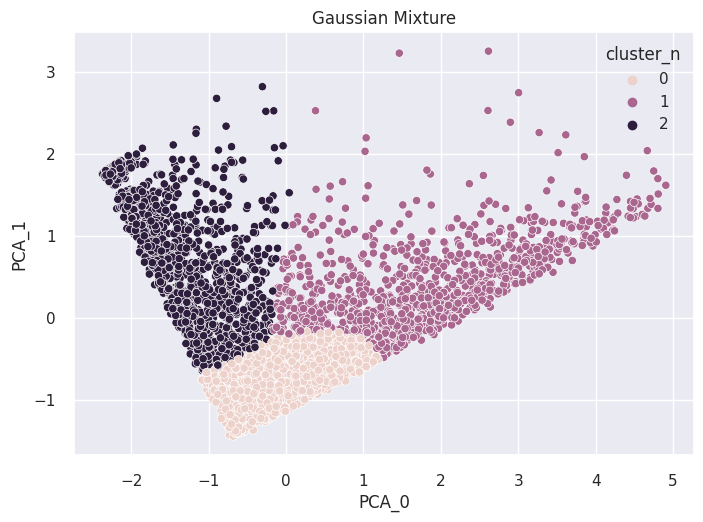

In [51]:
#
data_pca['cluster_n'] = gm_.labels_
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1', hue='cluster_n')\
.set_title("Gaussian Mixture");

### KMeans

In [52]:
scores = []
for n_clusters in range(3, 11):
    kmeans_ = KMeans(n_clusters=n_clusters)
    kmeans_.fit(X_PCA)
    
    scores.append({
    #    'eps': eps,
        'n_clusters' : n_clusters,
        'score': silhouette_score(X_PCA, kmeans_.labels_, metric='euclidean').round(2),  
        'ch_score': calinski_harabasz_score(X_PCA, kmeans_.labels_).round(2),
        'db_score': davies_bouldin_score(X_PCA, kmeans_.labels_).round(2),
    })

DF(scores).sort_values(by='score', ascending=False).head(3)

,n_clusters,score,ch_score,db_score
0,3,0.52,6025.51,0.64
1,4,0.49,6489.32,0.68
2,5,0.45,6314.70,0.74


In [53]:
#
n_clusters = DF(scores).n_clusters[np.argmax(DF(scores).score)]
print(f"Best score clasters count: {n_clusters}\n")
#
kmeans_ = KMeans(n_clusters=n_clusters)
kmeans_.fit(X_PCA)
S(kmeans_.labels_).value_counts()

Best score clasters count: 3



2    2118
0     990
1     813
Name: count, dtype: int64

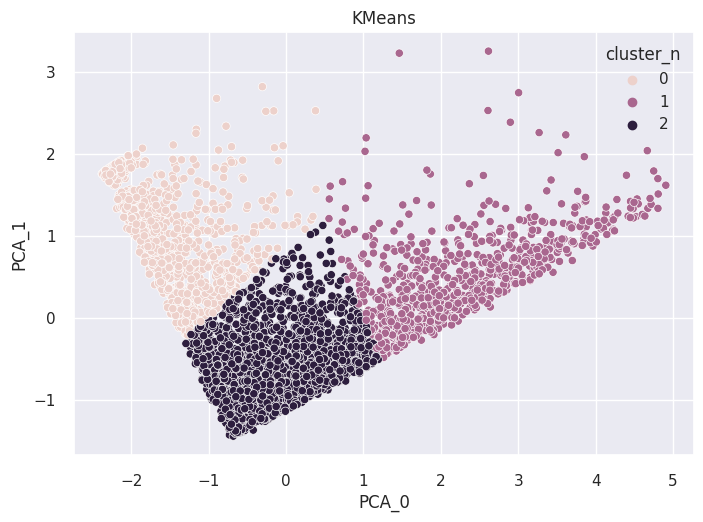

In [54]:
#
data_pca['cluster_n'] = kmeans_.labels_
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1', hue='cluster_n')\
.set_title("KMeans");

### Выбор метода кластеризации

>  Несмотря на то, что наилучший показатель коэффициента силуэта - **0.52** у метода `KMeans` при **3-x** кластерах, для получения оптимального количества кластеров воспользуемся методом `KElbowVisualizer` из библиотеки `yellowbrick`. Результатом будет **4-е** кластера. 


### KMeans (KElbow)

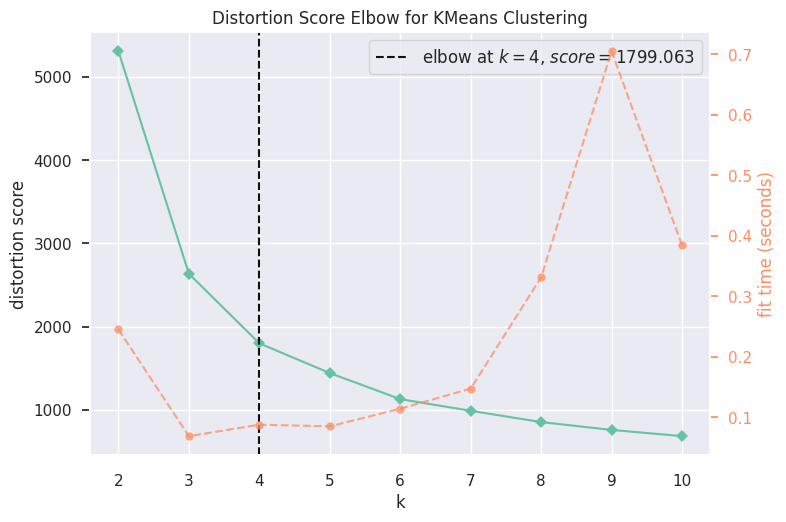

In [55]:
#
kelbow = KElbowVisualizer(KMeans(), k=10)
kelbow.fit(X_PCA)
kelbow.show();

In [56]:
#
n_clusters = kelbow.elbow_value_
print(f"elbow score clasters count: {n_clusters}\n")
#
kmeans_ = KMeans(n_clusters=n_clusters)
kmeans_.fit(X_PCA)
S(kmeans_.labels_).value_counts()

elbow score clasters count: 4



1    1621
2     957
3     921
0     422
Name: count, dtype: int64

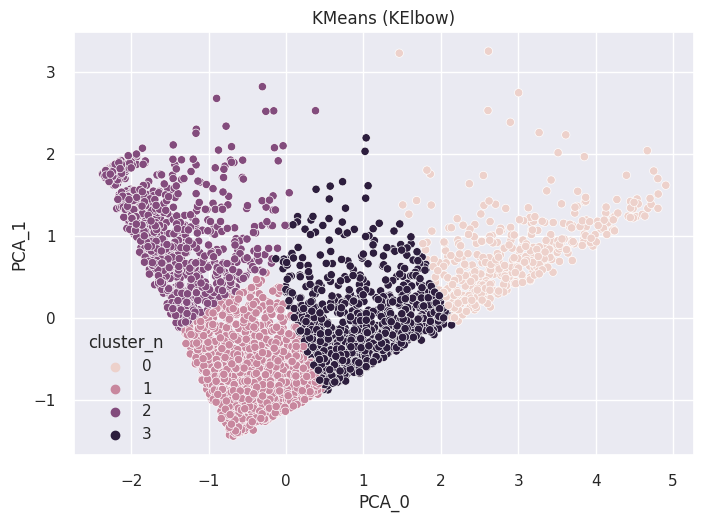

In [57]:
#
data_pca['cluster_n'] = kmeans_.labels_
sns.scatterplot(data=data_pca, x='PCA_0', y='PCA_1', hue='cluster_n')\
.set_title("KMeans (KElbow)");

## Визуализация кластеров KMeans в пространстве признаков RFM-таблицы

In [58]:
#
data_rfm['cluster_n'] = kmeans_.labels_

In [60]:
#
fig = px.scatter(data_frame=data_rfm, 
    x="Recency", 
    y="Monetary", 
    color="cluster_n",
    size='Frequency', 
    hover_data=['Frequency'],
    opacity=0.7,
    title='Отображение кластеров на плоскость [Monetary, Recency]',
    height = 780
)
fig.show()
#frame_figure(fig, "frames/frame_3a_2D.html", height="800")

In [61]:
fig = px.scatter_3d( data_frame=data_rfm, 
    x = 'Recency', 
    y = 'Frequency', 
    z = 'Monetary',
    size = 'Frequency',
    color = 'cluster_n',
    title='Отображение кластеров в пространстве признаков RFM',
    height = 780,  
)
#
fig.show()
#frame_figure(fig, "frames/frame_3a_3D.html", height="800")

> * Интерпритация кластеров по диаграммам выше возможна, но она будет скорее эмпирической. А нам нужна оценочная и более наглядная, имеющая метрические оценочные показатели.

Кратко можно описать, что:
-  кластер **3** - активные клиенты с высокой манетизацией и большим разбросом по количеству заказов
-  кластер **1** - условно - ушедшие или клиенты с очень низкой активностю.
-  кластер **2** - условно - малоактивные и/или новые клиенты
-  кластер **0** - основная масса активных клиентов со средними показателями

# Интерпритация полученых результатов кластеризации

In [62]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров 
                                  с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
        
        Return: go.Figure()
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устанавливаем свои размеры графика
        #width=800, # ширина (в пикселях)
        height=780, # высота (в пикселях)
    )
    # Возвращаем фигуру
    return fig

In [63]:
#
gr_data_rfm = data_rfm.groupby('cluster_n')[rfm_columns].agg('mean')
#gr_data_rfm

In [64]:
#
fig = plot_cluster_profile(gr_data_rfm, 4)
fig.show()
#frame_figure(fig, file_name="frames/frame_3b.html")

In [65]:
#
print("Количество клиентов по классам")
S(kmeans_.labels_).value_counts()

Количество клиентов по классам


1    1621
2     957
3     921
0     422
Name: count, dtype: int64

## Выбор метода интерпритации

У интерпритации RFM кластеров на полярной диаграмме выше есть свои небольшие минусы.  

1.  Показатель Recency, в отличии 2-х других, имеет противоположную (отрицательную коннотацию), что несколько затрудняет восприятие.
2.  Визуально сложнее дать сравнительную оценку между классами.

Поэтому пойдем немного другим путем, учитывая что RFM показатели в группах усредненные:  
-  Преобразуем Recency по смыслу в обратную характеристику.
-  Каждый признак оценим по привычной пятибальной системе (как вариант достаточный при 4-х кластерах).
-  Полученный результат отобразим в виде цветовой карты с анотацией.

> По факту оценка находиться в диапазоне $[0..5]$, что является шестибальной системой. Но так как точных критериев бальности по каждому RFM признаку у нас нет - будем считать это некой условностью. 

## Бальная оценка полученных кластеров и их интерпритация

In [66]:
#
gr_data_rfm_sc = DF(MinMaxScaler().fit_transform(gr_data_rfm), columns=gr_data_rfm.columns)
#gr_data_rfm_sc
gr_data_rfm_sc.Recency = 1 - gr_data_rfm_sc.Recency

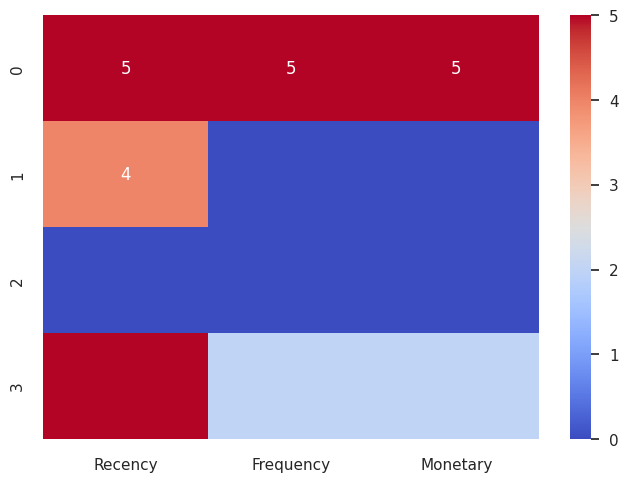

In [67]:
##
sns.heatmap(gr_data_rfm_sc.mul(5).round(), annot=True, cmap="coolwarm");

In [68]:
# 
print("Распределение клиентов по кластерам (%):")
print(S(kmeans_.labels_).value_counts(normalize=True).mul(100).round(1))

Распределение клиентов по кластерам (%):
1    41.3
2    24.4
3    23.5
0    10.8
Name: proportion, dtype: float64


>

**Интерпретируем кластеры клиентов на основе полученных показателей в баллах.** 

>  *Условно, т.к. выборка охватывает всего лишь годовой период:*

-  **3**  -  Активные (Все показатели высокие). Стоит заметить - это самая малочисленная группа - 11%
-  **1**  -  Ушедшие  (Все показатели на нуле)
-  **0**  -  Лояльные, с низкой и средней активностью.
-  **2**  -  Малоактивные. Самая большая группа - 41%. Редкие покупки, с низкой монетизацией, с заниженным усредненым показателем давности. Скорее всего сезонные целевые покупки и/или новые клиенты.



>  

**То же самое, но в виде полярной диаграммы при относительных нормированных показателях R.F.M.**

>  Интепритация схожа с методом выше, но менее наглядна.

In [70]:
#
fig = plot_cluster_profile(gr_data_rfm_sc, 4)
fig.show()
#frame_figure(fig, file_name="frames/frame_3с.html")

*  +  -

# Вывод

Используя методику RFM и методы кластеризации были получены и интерпретированы группы клиентов онлайн-магазина, позволяющие не только применять к ним различные маркетинговые стратегии, но и использовать полученные метки кластеров для более глубоко анализа и построения моделей машинного обучения другого типа.

*SF DST-148 Дмитрий Орлов Февраль 2024*

<a href="https://skillfactory.ru/courses/data-science">
    <img src="https://raw.githubusercontent.com/dhegl/sf_ds/64c052f95af5d042844ed56f765c2cbb566d1680/main/static/small.svg" alt="Онлайн-школа SkillFactory Курсы по Data Science" width="120px" align="left" >
</a>
